In [26]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [110]:
tissue_folder = "/mnt/c/Users/donna/Downloads/Thesis/data/scrna/expr_mats"

In [28]:
fat_df       = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/data/scrna/expr_mats/fat.csv", index_col=0)
all_cfdna_df = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/data/cfdna/cfmatje.csv", index_col=0)

In [29]:
cf_sample = "control--EE88138.hg38.frag.tsv_corrected.bam_fragment_features"
cell_type = "T_cell"

In [30]:
cf_series   = all_cfdna_df.loc[cf_sample]
scRNA_series = fat_df.loc[cell_type]

In [39]:
merged_df = pd.concat([cf_series, scRNA_series], axis=1, join='inner').dropna()
merged_df.columns = ["cfDNA", "scRNA"]

In [40]:
q1, q3 = np.percentile(merged_df["cfDNA"], [25, 75])
mask_iqr = merged_df["cfDNA"].between(q1, q3)
inliers  = merged_df[mask_iqr]
outliers = merged_df.loc[~mask_iqr]

In [49]:
r_all            , _ = pearsonr(merged_df["cfDNA"], merged_df["scRNA"])
slope_all, intercept_all = np.polyfit(merged_df["cfDNA"], merged_df["scRNA"], 1)

r_iqr             , _ = pearsonr(inliers["cfDNA"], inliers["scRNA"])
slope_iqr, intercept_iqr = np.polyfit(inliers["cfDNA"], inliers["scRNA"], 1)

x_vals = np.array([0.6, 1.05])
y_all  = slope_all * x_vals + intercept_all
y_iqr  = slope_iqr * x_vals + intercept_iqr

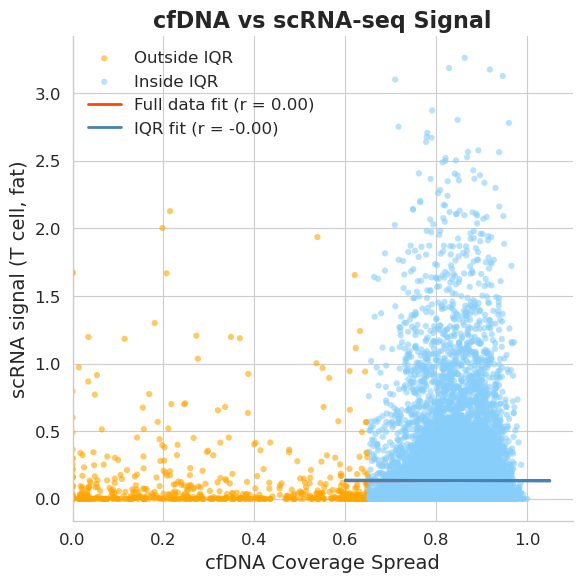

In [60]:
# === Recompute IQR with 1.5× fences ===
q1, q3 = np.percentile(merged_df["cfDNA"], [25, 75])
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

mask_iqr = merged_df["cfDNA"].between(lower_fence, upper_fence)
inliers  = merged_df.loc[mask_iqr]
outliers = merged_df.loc[~mask_iqr]

# === Compute fits ===
r_all, _               = pearsonr(merged_df["cfDNA"], merged_df["scRNA"])
slope_all, intercept_all = np.polyfit(merged_df["cfDNA"], merged_df["scRNA"], 1)

r_iqr, _               = pearsonr(inliers["cfDNA"], inliers["scRNA"])
slope_iqr, intercept_iqr = np.polyfit(inliers["cfDNA"], inliers["scRNA"], 1)

# === Line endpoints from x=1 to x=3 ===
x_vals = np.array([0.6, 1.05])
y_all  = slope_all * x_vals + intercept_all
y_iqr  = slope_iqr * x_vals + intercept_iqr

# === Plotting ===
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

fig, ax = plt.subplots(figsize=(6, 6))

# Outside‑IQR points (dark orange)
ax.scatter(
    outliers["cfDNA"], outliers["scRNA"],
    color="orange", alpha=0.6, s=20, edgecolor="none",
    label="Outside IQR"
)

# Inside‑IQR points (light blue)
ax.scatter(
    inliers["cfDNA"], inliers["scRNA"],
    color="lightskyblue", alpha=0.6, s=20, edgecolor="none",
    label="Inside IQR"
)

# Full‑data fit (orange line)
ax.plot(
    x_vals, y_all,
    color="orangered", linewidth=2,
    label=f"Full data fit (r = {r_all:.2f})"
)

# IQR‑only fit (blue line)
ax.plot(
    x_vals, y_iqr,
    color="steelblue", linewidth=2,
    label=f"IQR fit (r = {r_iqr:.2f})"
)

# Labels, title, and limits
ax.set_xlabel("cfDNA Coverage Spread", fontsize=14)
ax.set_ylabel("scRNA signal (T cell, fat)", fontsize=14)
ax.set_title("cfDNA vs scRNA-seq Signal", fontsize=16, fontweight="bold")
ax.set_xlim(0, 1.1)

# Refine ticks and spines
ax.tick_params(axis="both", labelsize=12)
sns.despine(ax=ax, trim=False)

# Legend
ax.legend(frameon=False, fontsize=12, loc="upper left")

# Save high‑resolution figure
plt.tight_layout()
plt.savefig(
    "/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/tcell_fat_pub_scatter.png",
    dpi=600, bbox_inches="tight"
)
plt.show()

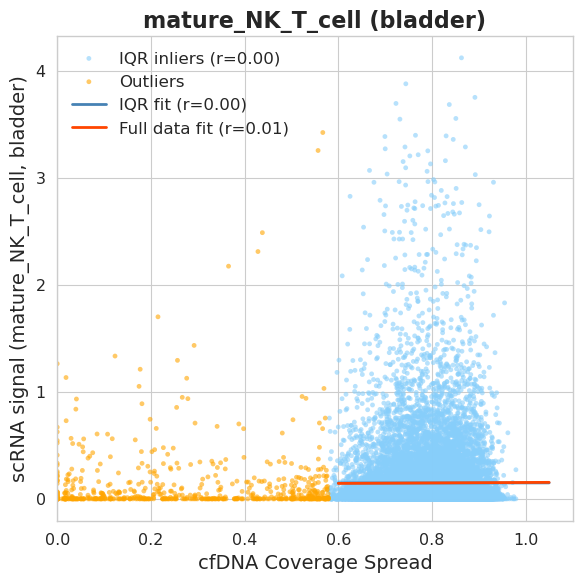

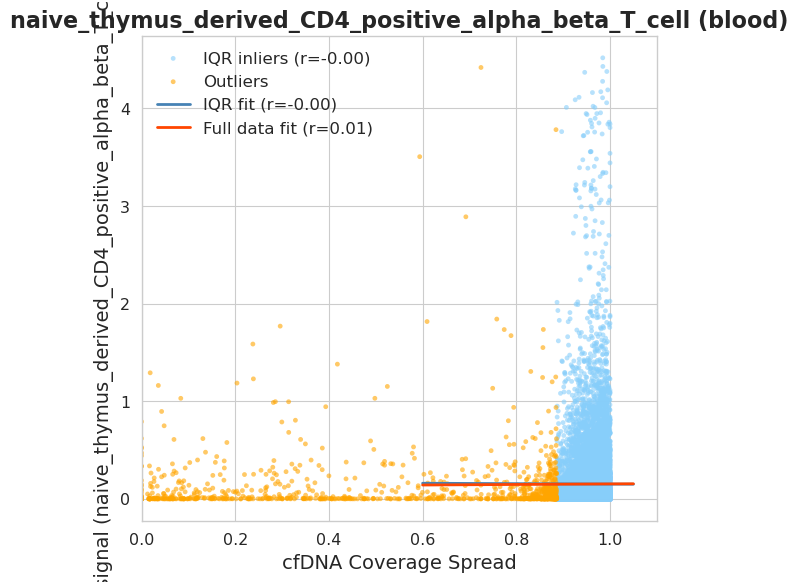

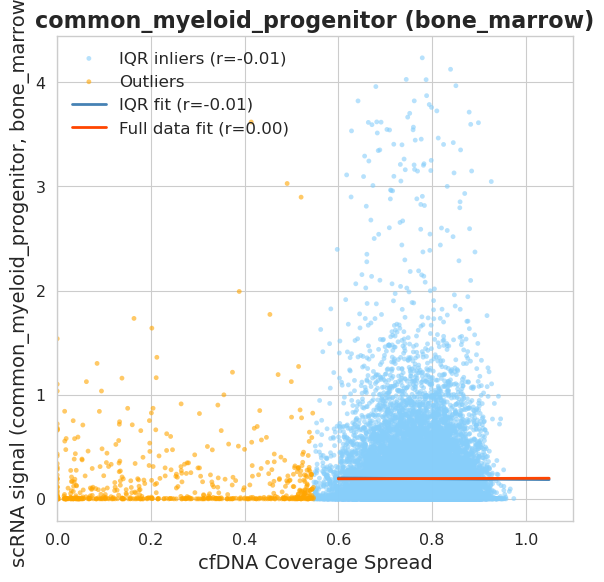

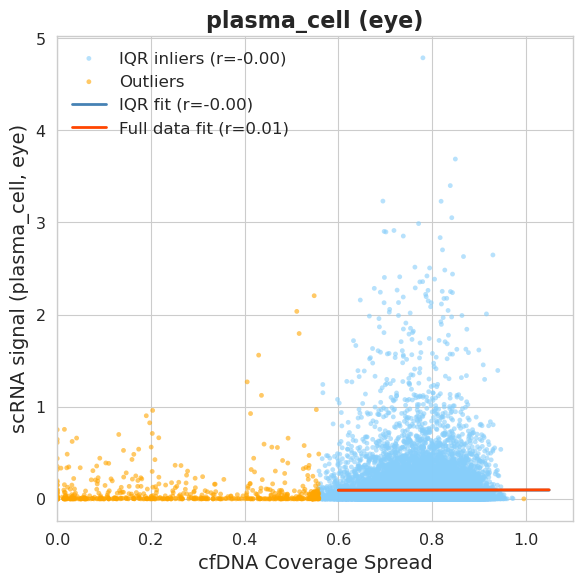

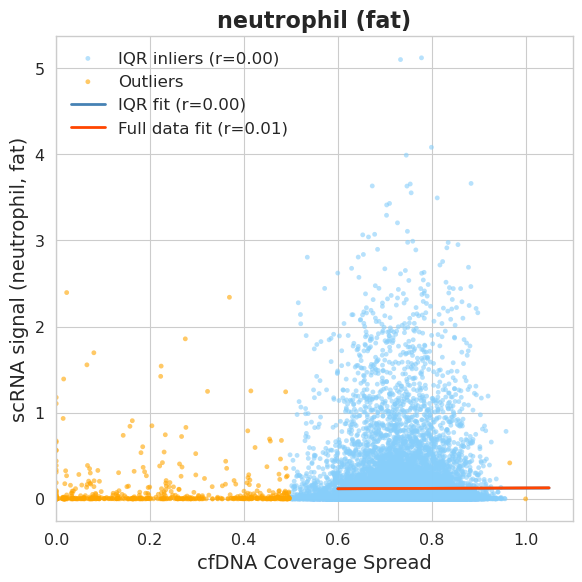

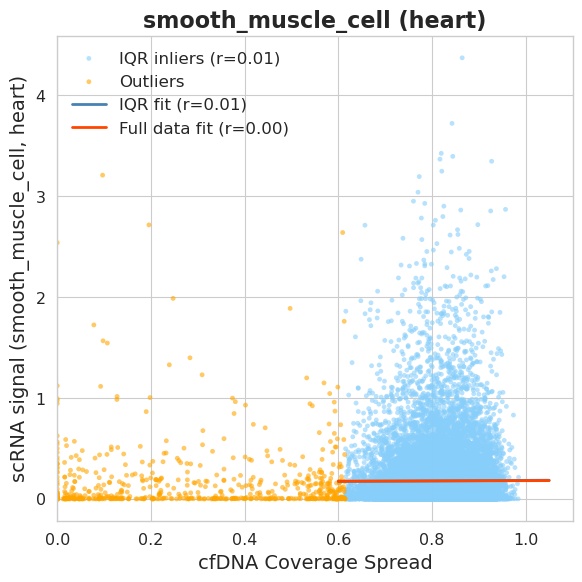

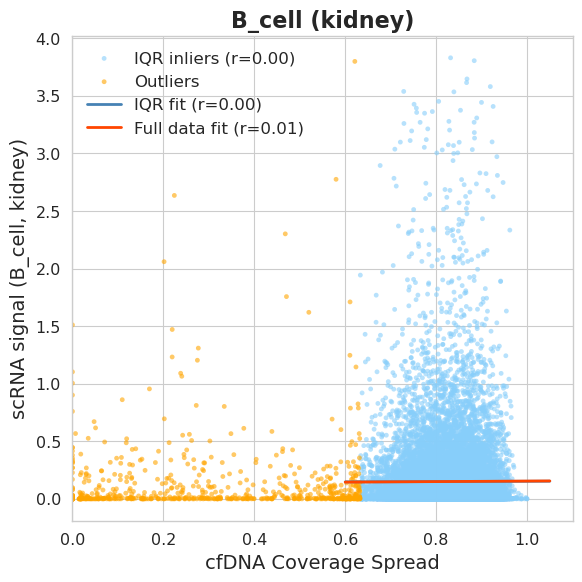

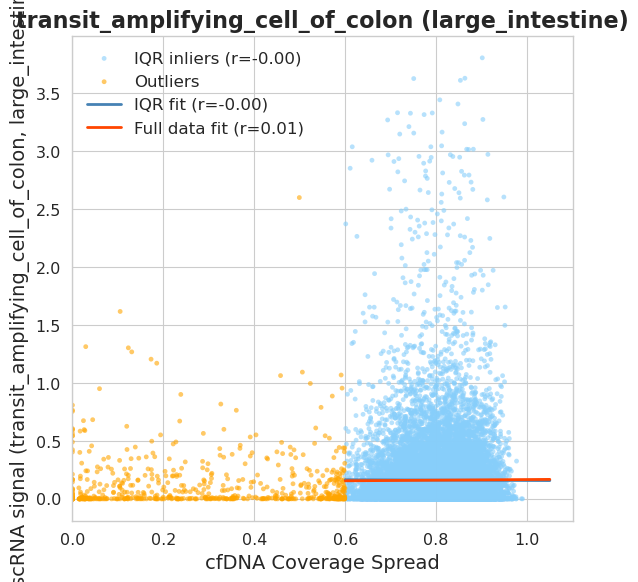

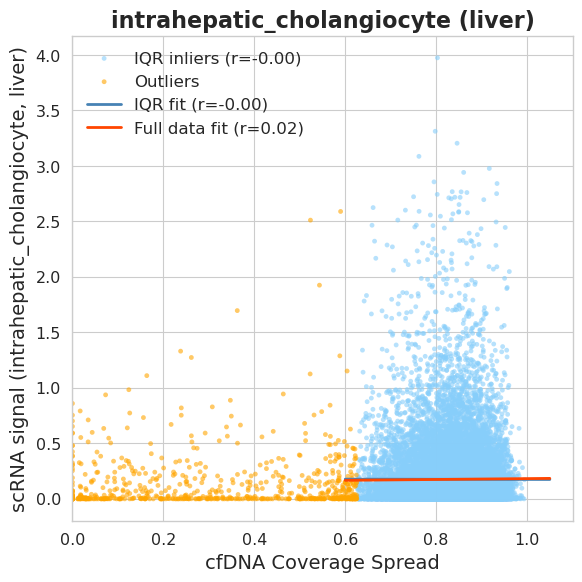

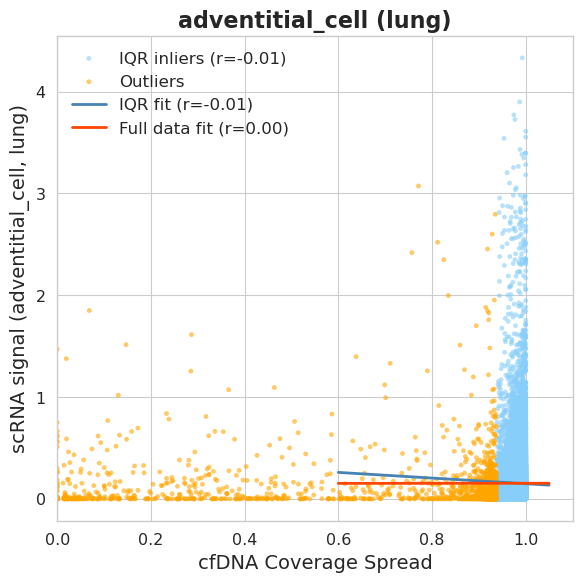

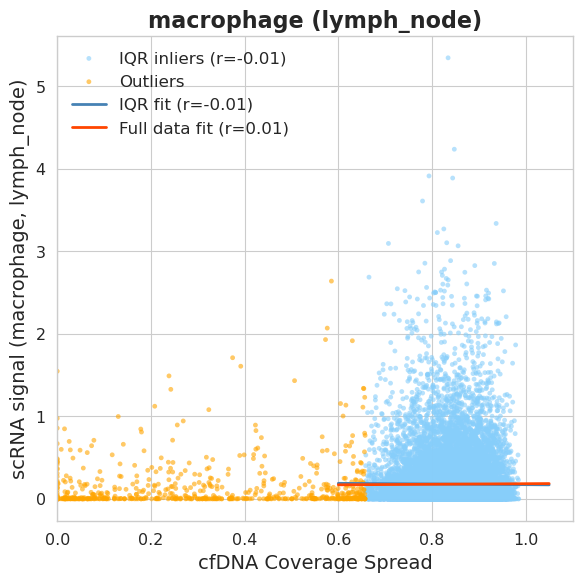

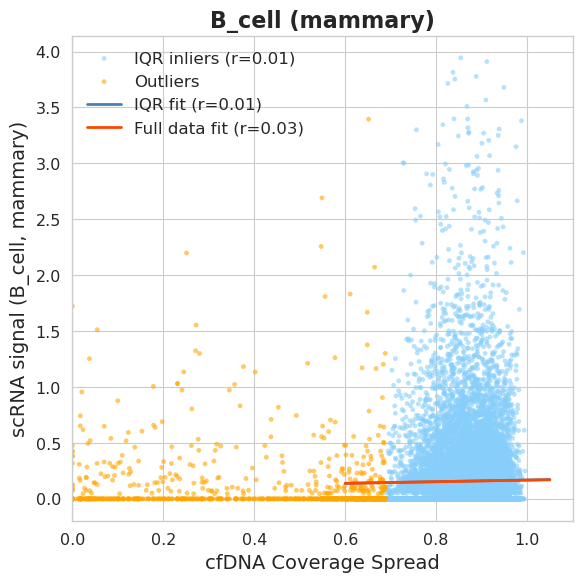

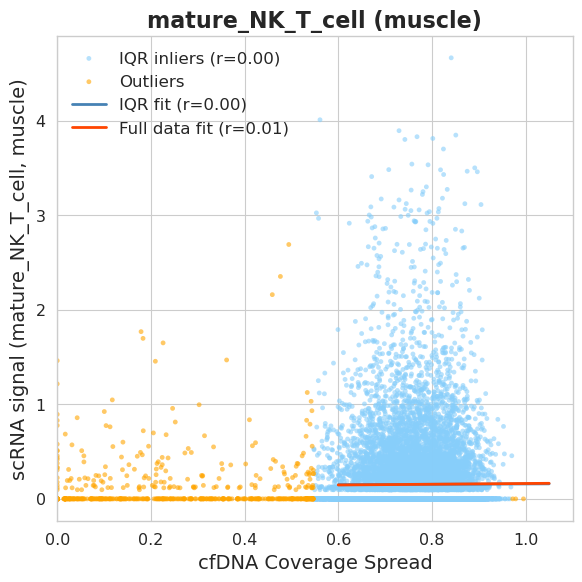

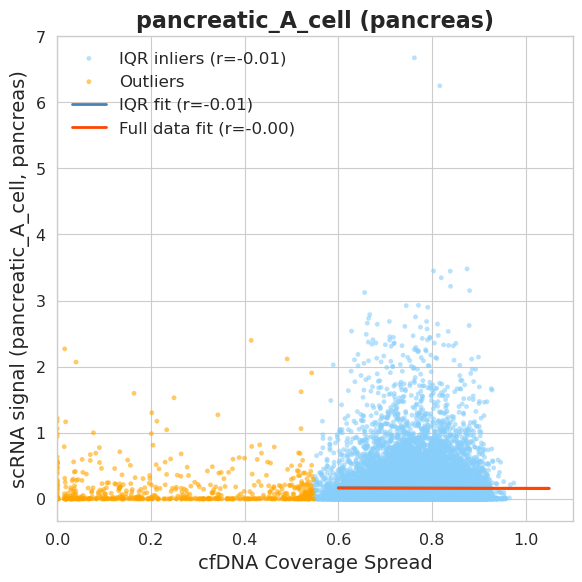

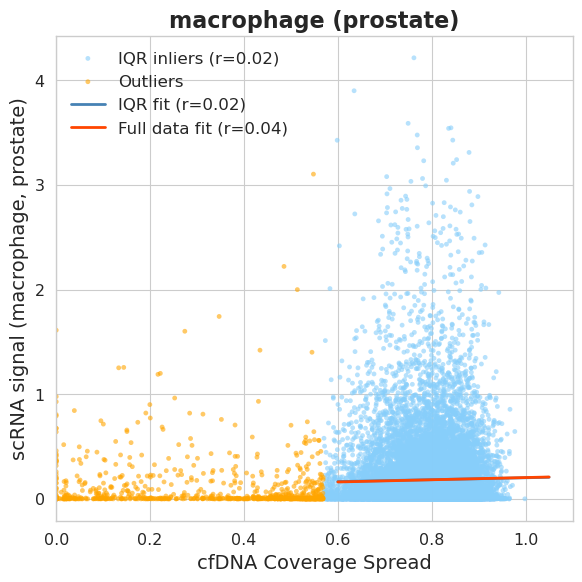

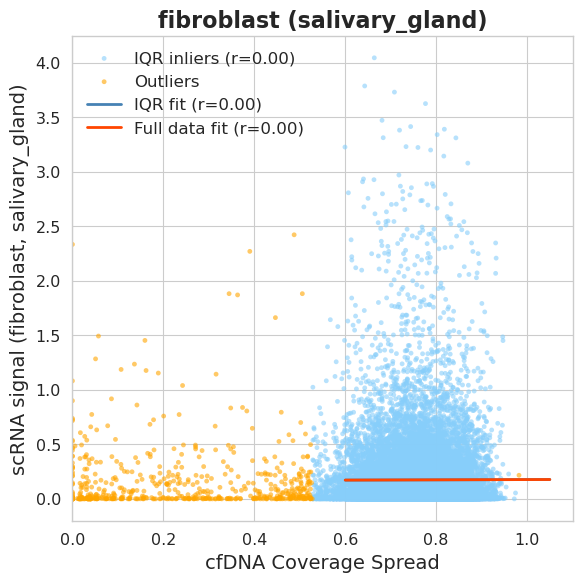

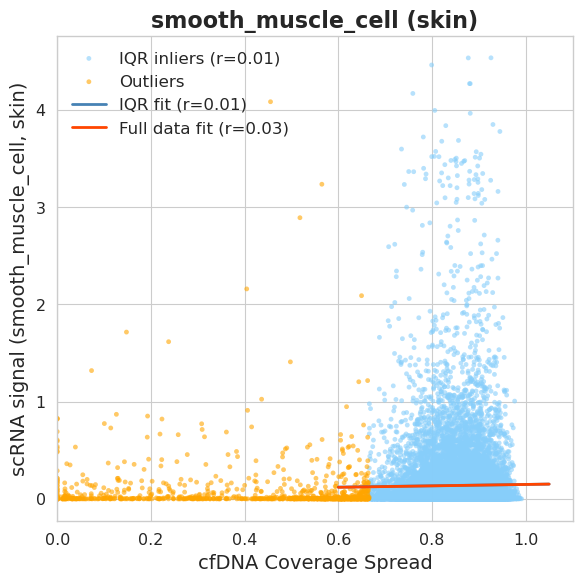

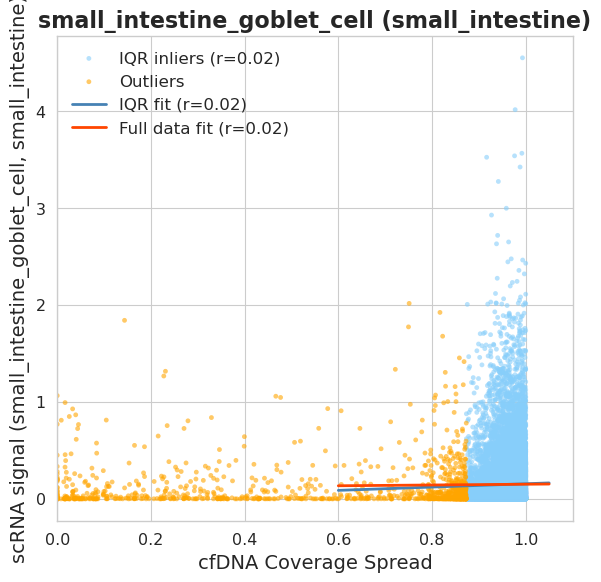

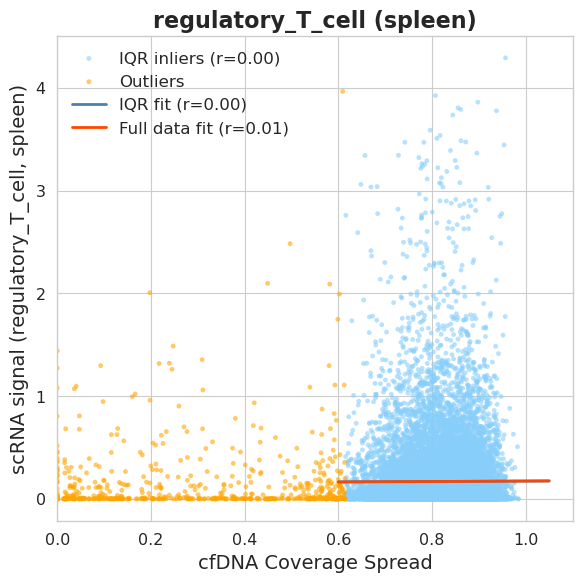

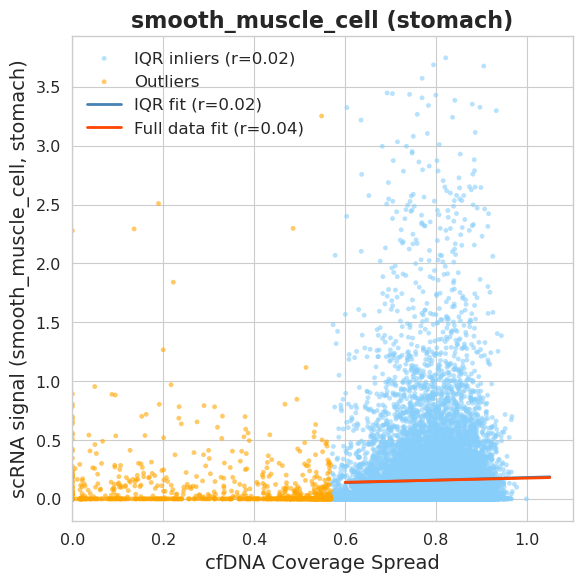

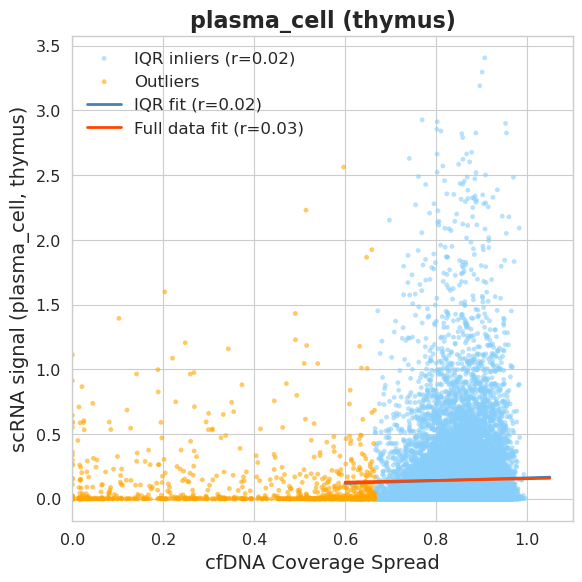

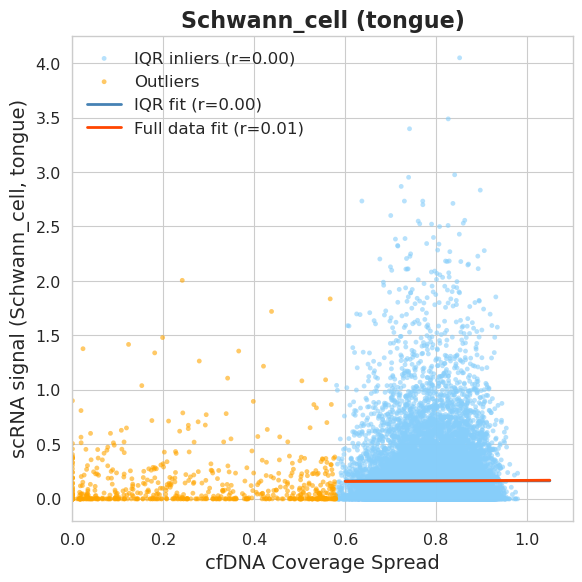

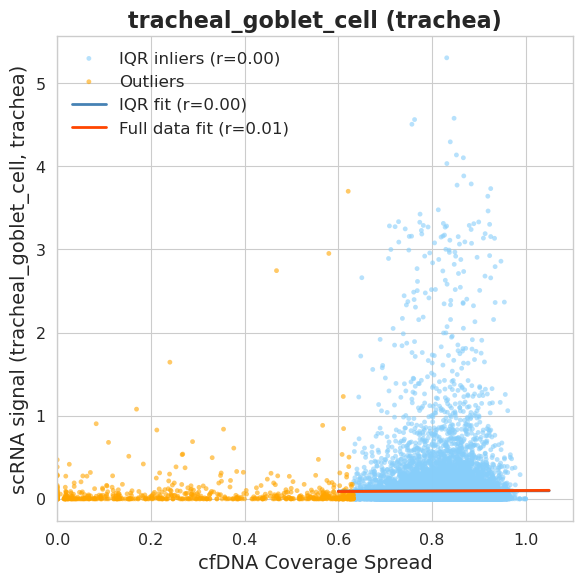

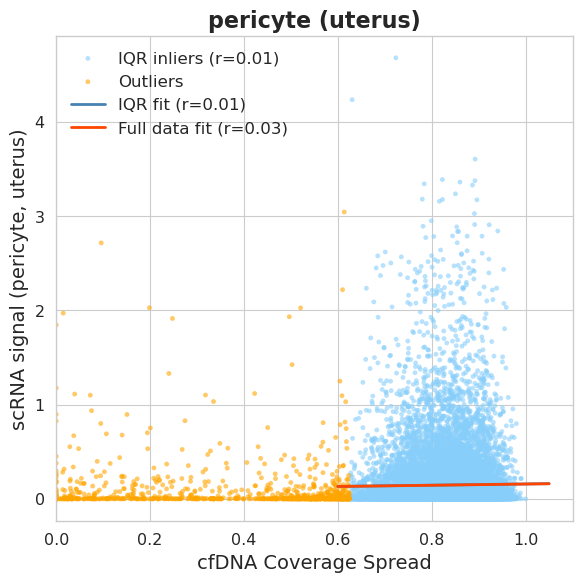

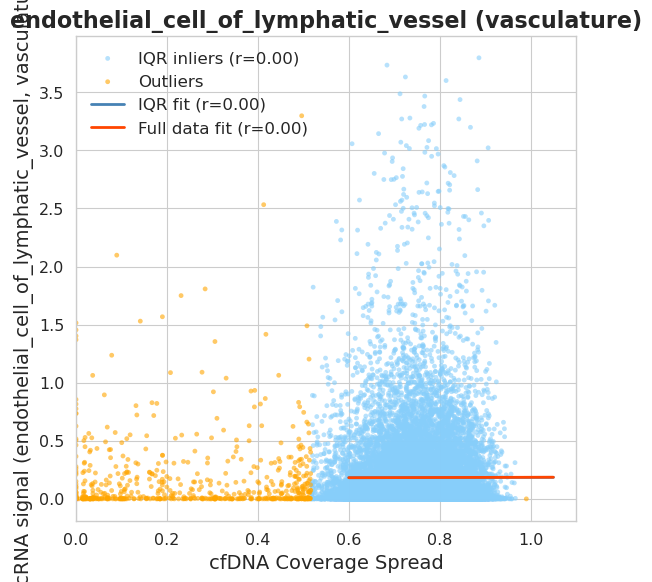

In [111]:
all_cfdna_df   =  pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/data/cfdna/cfmatje.csv", index_col=0)       # cfDNA samples matrix (rows=samples)

# List tissue files
tissue_files = [f for f in os.listdir(tissue_folder) if f.endswith(".csv")]

# Loop: pick random tissue, cell type, and cfDNA sample
for tissue_file in tissue_files:
    tissue_name = os.path.splitext(tissue_file)[0]
    scRNA_df    = pd.read_csv(os.path.join(tissue_folder, tissue_file), index_col=0)

    # Random selections
    cell_type = random.choice(scRNA_df.index.tolist())
    cf_sample = random.choice(all_cfdna_df.index.tolist())

    scRNA_series = scRNA_df.loc[cell_type]
    cf_series    = all_cfdna_df.loc[cf_sample]

    # Merge by position
    n = min(len(cf_series), len(scRNA_series))
    merged_df = pd.DataFrame({
        "cfDNA": cf_series.values[:n],
        "scRNA": scRNA_series.values[:n]
    })

    # Compute 1.5×IQR fences
    q1, q3 = np.percentile(merged_df["cfDNA"], [25, 75])
    iqr    = q3 - q1
    lower_fence, upper_fence = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask_iqr = merged_df["cfDNA"].between(lower_fence, upper_fence)
    inliers  = merged_df.loc[mask_iqr]
    outliers = merged_df.loc[~mask_iqr]

    # Compute fits
    # Full data
    slope_all, intercept_all = np.polyfit(merged_df["cfDNA"], merged_df["scRNA"], 1)
    r_all, _ = pearsonr(merged_df["cfDNA"], merged_df["scRNA"])
    # IQR-only
    slope_iqr, intercept_iqr = np.polyfit(inliers["cfDNA"], inliers["scRNA"], 1)
    r_iqr, _ = pearsonr(inliers["cfDNA"], inliers["scRNA"])

    # Line endpoints
    x_vals = np.array([0.6, 1.05])
    y_all  = slope_all * x_vals + intercept_all
    y_iqr  = slope_iqr * x_vals + intercept_iqr

    # Plot
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.3)
    plt.figure(figsize=(6, 6))

    plt.scatter(
        inliers["cfDNA"], inliers["scRNA"],
        color="lightskyblue", alpha=0.6, s=12, edgecolor="none",
        label=f"IQR inliers (r={r_iqr:.2f})"
    )
    plt.scatter(
        outliers["cfDNA"], outliers["scRNA"],
        color="orange", alpha=0.6, s=12, edgecolor="none",
        label="Outliers"
    )
    plt.plot(
        x_vals, y_iqr,
        color="steelblue", linewidth=2,
        label=f"IQR fit (r={r_iqr:.2f})"
    )
    plt.plot(
        x_vals, y_all,
        color="orangered", linewidth=2,
        label=f"Full data fit (r={r_all:.2f})"
    )

    plt.xlabel("cfDNA Coverage Spread", fontsize=14)
    plt.ylabel(f"scRNA signal ({cell_type}, {tissue_name})", fontsize=14)
    plt.title(f"{cell_type} ({tissue_name})", fontsize=16, fontweight="bold")
    plt.xlim(0, 1.1)

    plt.legend(frameon=False, fontsize=12, loc="upper left")
    plt.tight_layout()

    # # Save high-resolution
    # out_file = f"{tissue_name}_{cell_type}_{cf_sample}.png"
    # plt.savefig(os.path.join(output_dir, out_file), dpi=600, bbox_inches="tight")
    plt.show()


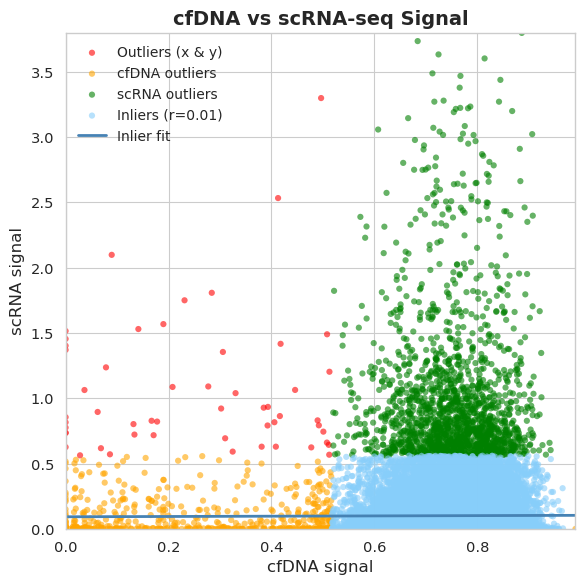

In [113]:
# 1) Compute 1.5×IQR fences for cfDNA (x) and scRNA (y)
q1x, q3x = np.percentile(merged_df["cfDNA"], [25, 75])
iqr_x = q3x - q1x
lower_x, upper_x = q1x - 1.5 * iqr_x, q3x + 1.5 * iqr_x

q1y, q3y = np.percentile(merged_df["scRNA"], [25, 75])
iqr_y = q3y - q1y
lower_y, upper_y = q1y - 1.5 * iqr_y, q3y + 1.5 * iqr_y

# 2) Masks for inliers/outliers
mask_x = merged_df["cfDNA"].between(lower_x, upper_x)
mask_y = merged_df["scRNA"].between(lower_y, upper_y)

# 3) Categorize points
inliers       = merged_df[mask_x & mask_y]
x_outliers    = merged_df[~mask_x & mask_y]
y_outliers    = merged_df[mask_x & ~mask_y]
both_outliers = merged_df[~mask_x & ~mask_y]

# 4) Fit regression on inliers only
m_in, b_in = np.polyfit(inliers["cfDNA"], inliers["scRNA"], 1)
r_in, _    = pearsonr(inliers["cfDNA"], inliers["scRNA"])

# 5) Define line endpoints over observed cfDNA range
x_min, x_max = merged_df["cfDNA"].min(), merged_df["cfDNA"].max()
x_vals = np.array([x_min, x_max])
y_vals = m_in * x_vals + b_in

# 6) Plot all categories and inlier fit
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(6, 6))

plt.scatter(both_outliers["cfDNA"], both_outliers["scRNA"],
            color="red", alpha=0.6, s=20, edgecolor="none",
            label="Outliers (x & y)")
plt.scatter(x_outliers["cfDNA"], x_outliers["scRNA"],
            color="orange", alpha=0.6, s=20, edgecolor="none",
            label="cfDNA outliers")
plt.scatter(y_outliers["cfDNA"], y_outliers["scRNA"],
            color="green", alpha=0.6, s=20, edgecolor="none",
            label="scRNA outliers")
plt.scatter(inliers["cfDNA"], inliers["scRNA"],
            color="lightskyblue", alpha=0.6, s=20, edgecolor="none",
            label=f"Inliers (r={r_in:.2f})")

# Regression line (inliers)
plt.plot(x_vals, y_vals,
         color="steelblue", linewidth=2,
         label="Inlier fit")

plt.xlabel("cfDNA signal", fontsize=12)
plt.ylabel("scRNA signal", fontsize=12)
plt.title("cfDNA vs scRNA-seq Signal", fontsize=14, fontweight="bold")
plt.xlim(0, x_max)
plt.ylim(0, merged_df["scRNA"].max())

plt.legend(frameon=False, fontsize=10, loc="upper left")
plt.tight_layout()
plt.show()

In [89]:
atac_tissue_folder = "/mnt/c/Users/donna/Downloads/Thesis/data/atac_files/cell_type_mean" 
cfdna_path         = "/mnt/c/Users/donna/Downloads/Thesis/data/cfdna/ataccfmatje.csv"

In [90]:
all_cfdna_df = pd.read_csv(cfdna_path, index_col=0)

In [91]:
# List sci-ATAC tissue files
tissue_files = [f for f in os.listdir(atac_tissue_folder) if f.endswith(".csv")]


In [87]:
cf_sample = "control--EE88129.hg38.frag.tsv_corrected.bam_fragment_features"

# Extract series
atac_series = atac_df.loc[cell_type]
cf_series   = all_cfdna_df.loc[cf_sample]

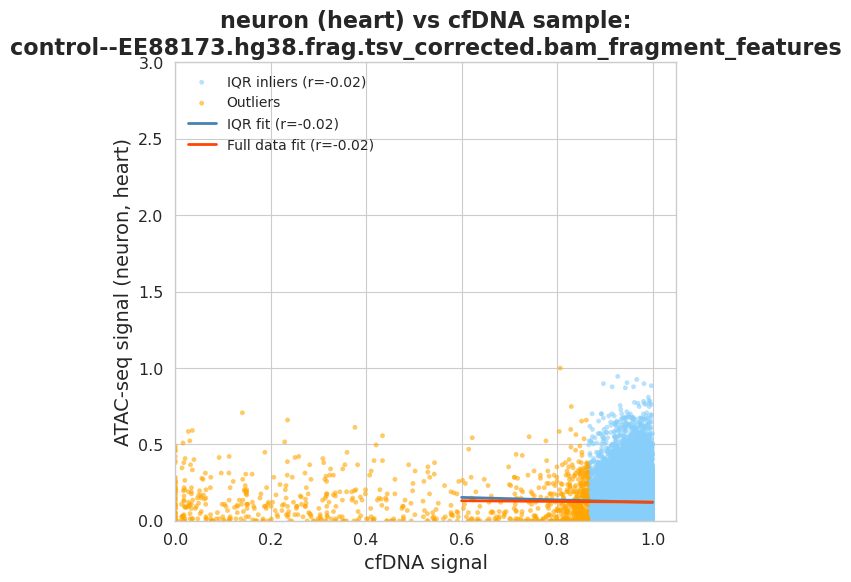

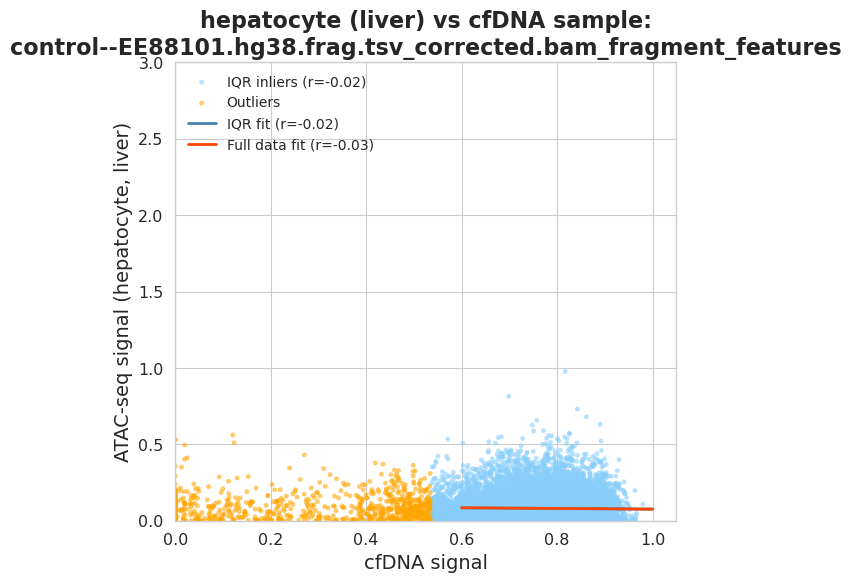

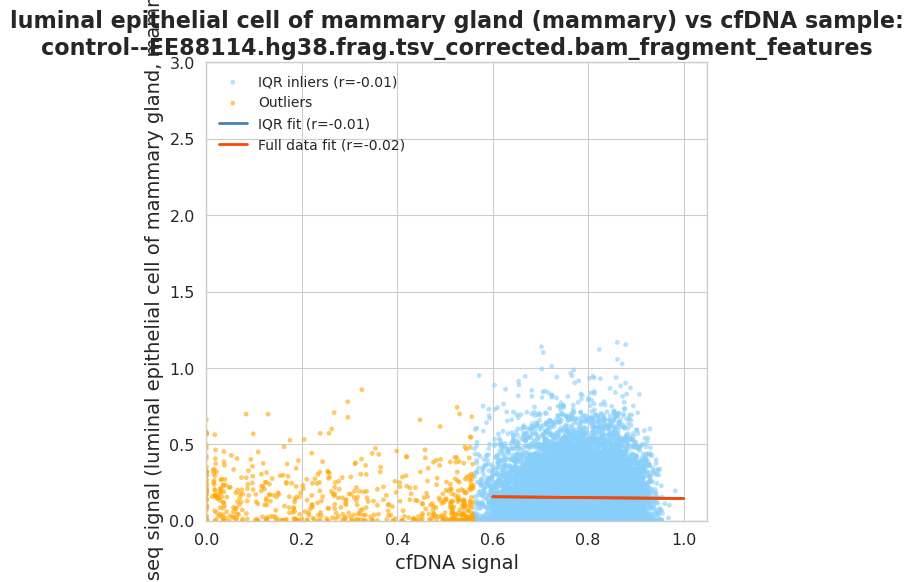

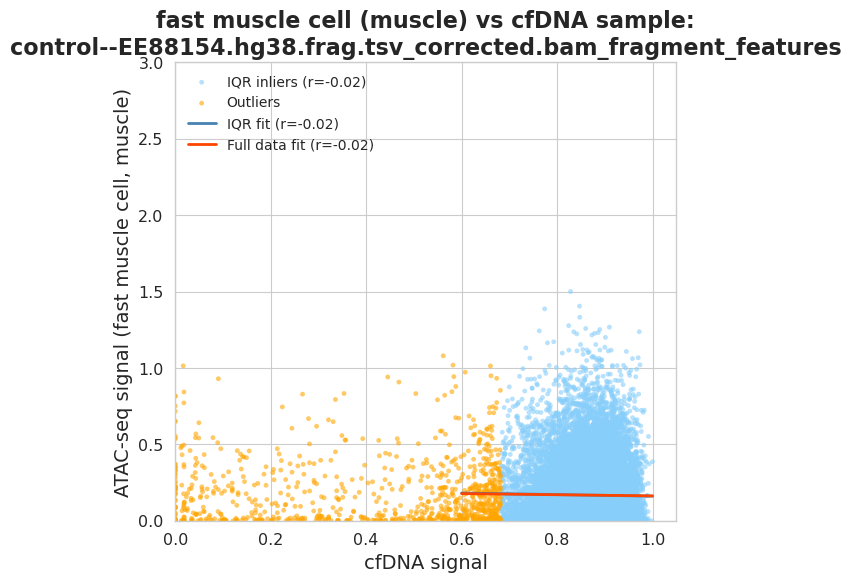

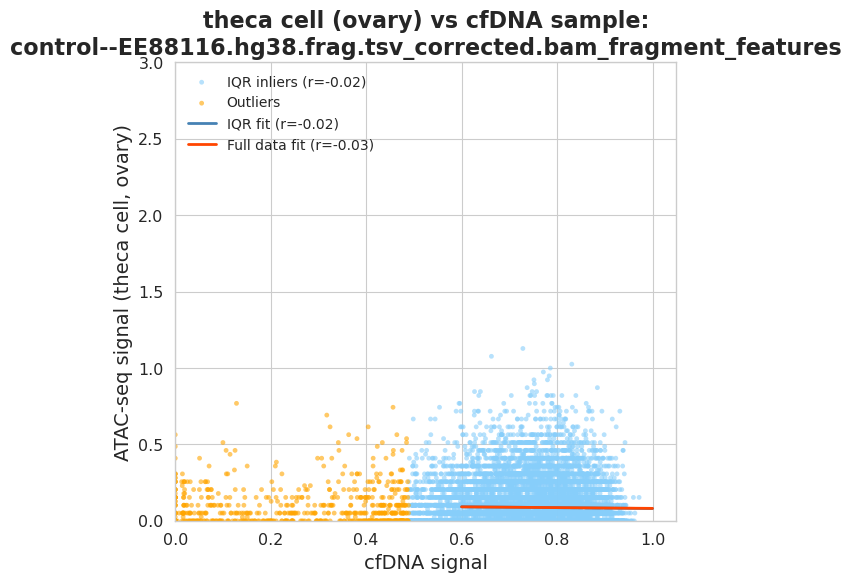

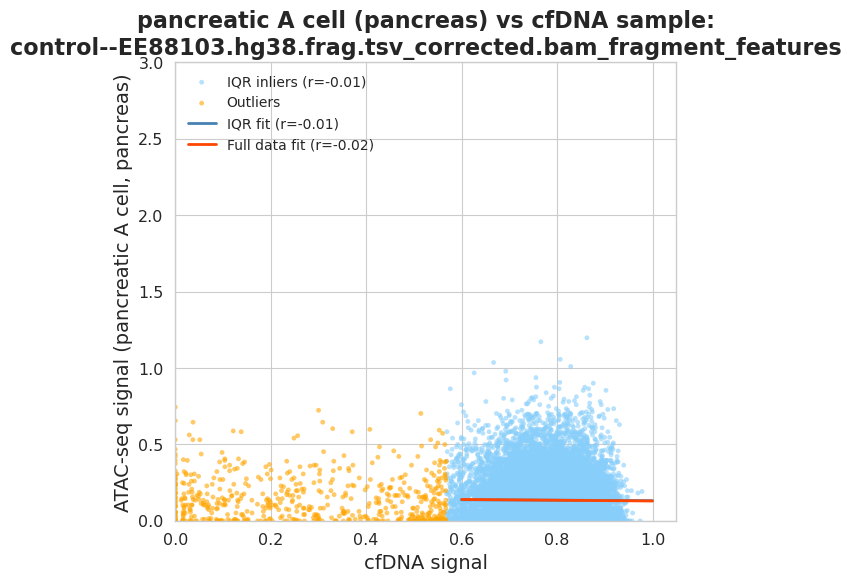

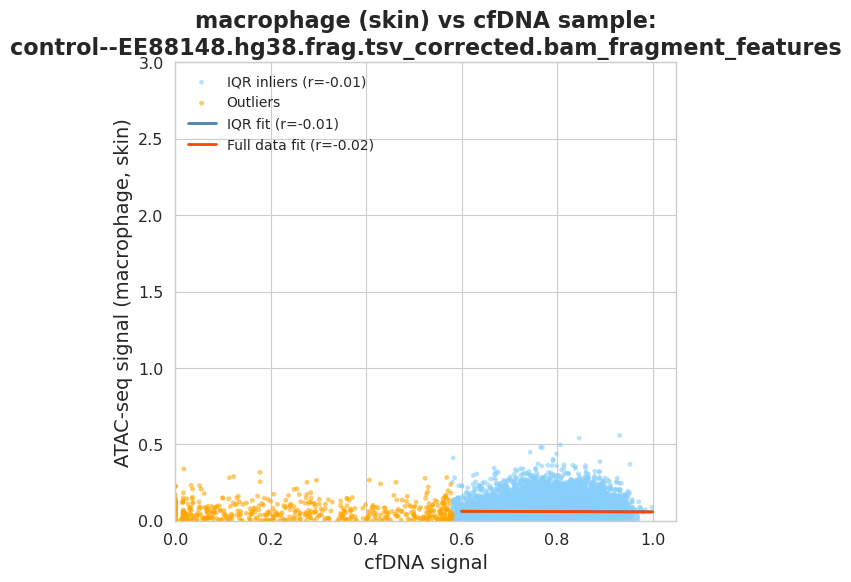

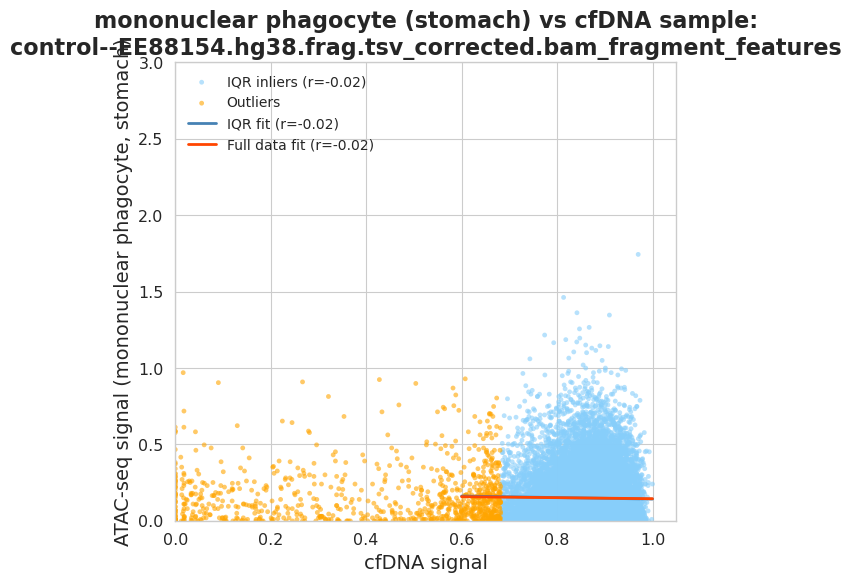

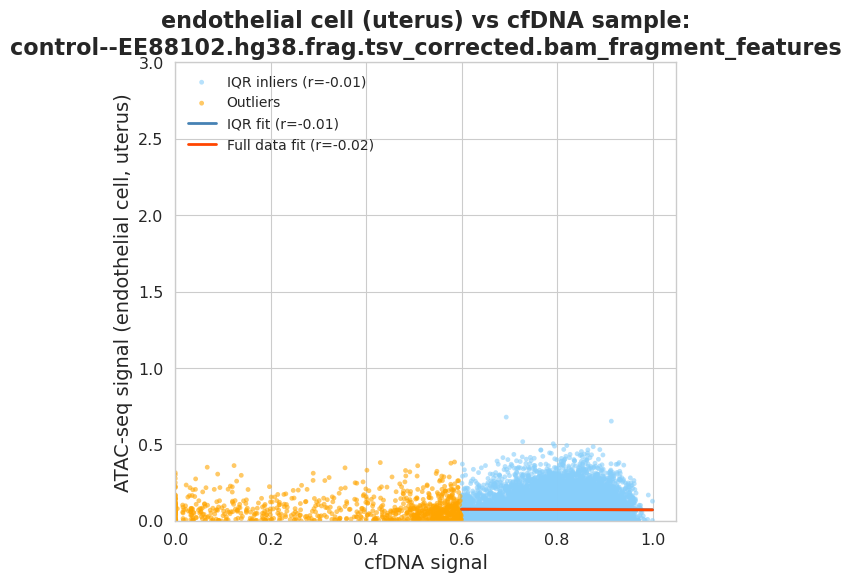

In [99]:
# Loop through each tissue CSV
for tissue_file in tissue_files:
    tissue_name = os.path.splitext(tissue_file)[0]
    atac_df = pd.read_csv(os.path.join(atac_tissue_folder, tissue_file), index_col=0)
    
    # Randomly select one cell type (row) from this tissue
    cell_type = random.choice(atac_df.index.tolist())
    atac_series = atac_df.loc[cell_type]
    
    # Randomly select one cfDNA sample (row)
    cf_sample = random.choice(all_cfdna_df.index.tolist())
    cf_series = all_cfdna_df.loc[cf_sample]
    
    # Merge on shared genomic regions
    merged_df = pd.DataFrame({
        "cfDNA": cf_series.values,
        "ATAC":  atac_series.values
    })
    merged_df.columns = ["cfDNA", "ATAC"]
    
    # Compute 1.5×IQR fences on cfDNA axis
    q1, q3 = np.percentile(merged_df["cfDNA"], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    mask_iqr = merged_df["cfDNA"].between(lower_fence, upper_fence)
    
    # Split inliers and outliers
    inliers  = merged_df.loc[mask_iqr]
    outliers = merged_df.loc[~mask_iqr]
    
    # Full-data fit
    m_all, b_all = np.polyfit(merged_df["cfDNA"], merged_df["ATAC"], 1)
    r_all, _     = pearsonr(merged_df["cfDNA"], merged_df["ATAC"])
    
    # IQR-only fit
    m_iqr, b_iqr = np.polyfit(inliers["cfDNA"], inliers["ATAC"], 1)
    r_iqr, _     = pearsonr(inliers["cfDNA"], inliers["ATAC"])
    
    # Line endpoints covering the data range
    x_min, x_max = merged_df["cfDNA"].min(), merged_df["cfDNA"].max()
    x_vals = np.array([0.6, 1])
    y_all  = m_all * x_vals + b_all
    y_iqr  = m_iqr * x_vals + b_iqr
    
    # === Plotting ===
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.3)
    plt.figure(figsize=(6, 6))
    
    # Plot inliers (blue) and outliers (orange)
    plt.scatter(
        inliers["cfDNA"], inliers["ATAC"],
        color="lightskyblue", alpha=0.6, s=12, edgecolor="none",
        label=f"IQR inliers (r={r_iqr:.2f})"
    )
    plt.scatter(
        outliers["cfDNA"], outliers["ATAC"],
        color="orange", alpha=0.6, s=12, edgecolor="none",
        label=f"Outliers"
    )
    
    # Plot regression lines
    plt.plot(
        x_vals, y_iqr,
        color="steelblue", linewidth=2,
        label=f"IQR fit (r={r_iqr:.2f})"
    )
    plt.plot(
        x_vals, y_all,
        color="orangered", linewidth=2,
        label=f"Full data fit (r={r_all:.2f})"
    )
    
    # Labels & title including tissue, cell type, cfDNA sample
    plt.xlabel("cfDNA signal", fontsize=14)
    plt.ylabel(f"ATAC-seq signal ({cell_type}, {tissue_name})", fontsize=14)
    plt.title(
        f"{cell_type} ({tissue_name}) vs cfDNA sample:\n{cf_sample}",
        fontsize=16, fontweight="bold"
    )
    plt.xlim(0, 1.05)
    plt.ylim(0, 3)
    
    plt.legend(frameon=False, fontsize=10, loc="upper left")
    plt.tight_layout()
    
    # Save figure
    # out_path = os.path.join(output_dir, f"{tissue_name}_{cell_type}_{cf_sample}.png")
    # plt.savefig(out_path, dpi=600, bbox_inches="tight")
    # plt.close()
    
    # Break after first plot to explore representative example
    # break

In [100]:
tissue_name = "pancreas"
atac_df = pd.read_csv(os.path.join(atac_tissue_folder, f"{tissue_name}.csv"), index_col=0)
cell_type = "pancreatic A cell"

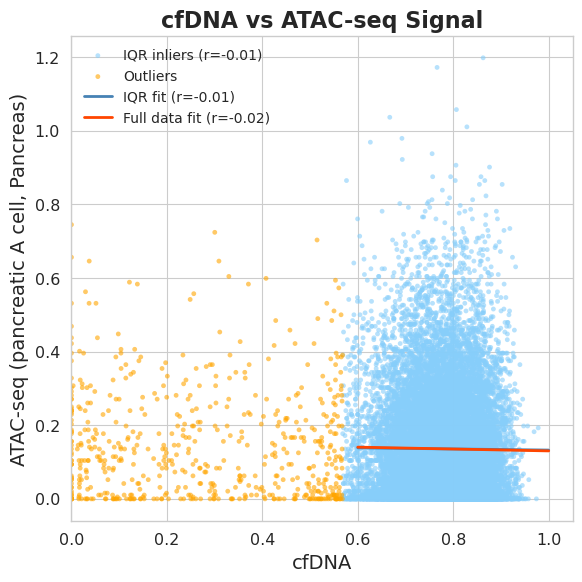

In [103]:
# Select specific cfDNA sample
cf_sample = "control--EE88103.hg38.frag.tsv_corrected.bam_fragment_features"

# Extract series
atac_series = atac_df.loc[cell_type]
cf_series   = all_cfdna_df.loc[cf_sample]

# Merge by positional alignment
n = min(len(cf_series), len(atac_series))
merged_df = pd.DataFrame({
    "cfDNA": cf_series.values[:n],
    "ATAC":  atac_series.values[:n]
})

# Compute 1.5×IQR fences on cfDNA
q1, q3 = np.percentile(merged_df["cfDNA"], [25, 75])
iqr = q3 - q1
lower_fence, upper_fence = q1 - 1.5 * iqr, q3 + 1.5 * iqr
mask_iqr = merged_df["cfDNA"].between(lower_fence, upper_fence)

# Split inliers and outliers
inliers  = merged_df.loc[mask_iqr]
outliers = merged_df.loc[~mask_iqr]

# Fit on full data and IQR-only
m_all, b_all = np.polyfit(merged_df["cfDNA"], merged_df["ATAC"], 1)
r_all, _     = pearsonr(merged_df["cfDNA"], merged_df["ATAC"])
m_iqr, b_iqr = np.polyfit(inliers["cfDNA"], inliers["ATAC"], 1)
r_iqr, _     = pearsonr(inliers["cfDNA"], inliers["ATAC"])

# Define line endpoints (user-specified range)
x_vals = np.array([0.6, 1])
y_all  = m_all * x_vals + b_all
y_iqr  = m_iqr * x_vals + b_iqr

# === Plotting ===
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.3)

plt.figure(figsize=(6, 6))
# Inliers in blue
plt.scatter(
    inliers["cfDNA"], inliers["ATAC"],
    color="lightskyblue", alpha=0.6, s=12, edgecolor="none",
    label=f"IQR inliers (r={r_iqr:.2f})"
)
# Outliers in orange
plt.scatter(
    outliers["cfDNA"], outliers["ATAC"],
    color="orange", alpha=0.6, s=12, edgecolor="none",
    label="Outliers"
)
# IQR regression line (blue)
plt.plot(
    x_vals, y_iqr,
    color="steelblue", linewidth=2,
    label=f"IQR fit (r={r_iqr:.2f})"
)
# Full-data regression line (orange-red)
plt.plot(
    x_vals, y_all,
    color="orangered", linewidth=2,
    label=f"Full data fit (r={r_all:.2f})"
)

# Labels & title (show only cell type and tissue)
plt.xlabel("cfDNA", fontsize=14)
plt.ylabel(f"ATAC-seq ({cell_type}, Pancreas)", fontsize=14)
plt.title("cfDNA vs ATAC-seq Signal", fontsize=16, fontweight="bold")
plt.xlim(0, 1.05)

plt.legend(frameon=False, fontsize=10, loc="upper left")
plt.tight_layout()

# Save high-quality figure
plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/atac_scatter.png", dpi=600, bbox_inches="tight")
plt.show()